In [2]:
# imports

import pickle
import numpy as np
import pandas as pd
import librosa
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt
import random
import torchvision
import torch.utils.data as utils
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset, random_split
from torch.autograd import Variable
import torchvision.utils
import time
import copy
from torch.optim import lr_scheduler
import os
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F




## hyper-parameters

In [3]:
random_seed = 42

## Preprocessing and Loading dataset

In [4]:
with open('dataset.pkl', 'rb') as f:
    data = pickle.load(f)

df_uwb_data = data['data_CIR']
df_uwb = data['data_t']

In [5]:
## Train & valdiation & Test split
X_train, X_test, y_train, y_test = train_test_split(df_uwb_data.values, df_uwb['NLOS'].values, test_size=0.1, random_state=random_seed, stratify=df_uwb['NLOS'].values)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=random_seed, stratify=y_train)

print('X_train_shape {}, y_train_shape {} : '.format(X_train.shape, y_train.shape))
# print('X_val_shape {}, y_val_shape {} : '.format(X_val.shape, y_val.shape))
print('X_test_shape {}, y_test_shape {} : '.format(X_test.shape, y_test.shape))

print("Train NLOS 0 count :", len(y_train[y_train==0])) 
print("Train NLOS 1 count :", len(y_train[y_train==1])) 
# print("Validation NLOS 0 count :", len(y_val[y_val==0])) 
# print("Validation NLOS 1 count :", len(y_val[y_val==1])) 
print("Test NLOS 0 count :", len(y_test[y_test==0])) 
print("Test NLOS 0 count :", len(y_test[y_test==1]))


X_train_shape (37800, 1016), y_train_shape (37800,) : 
X_test_shape (4200, 1016), y_test_shape (4200,) : 
Train NLOS 0 count : 18900
Train NLOS 1 count : 18900
Test NLOS 0 count : 2100
Test NLOS 0 count : 2100


## Amplitude to dB Scale

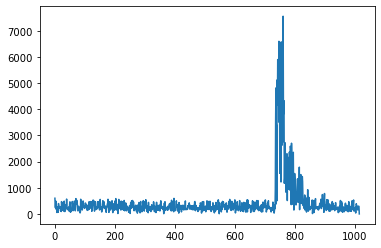

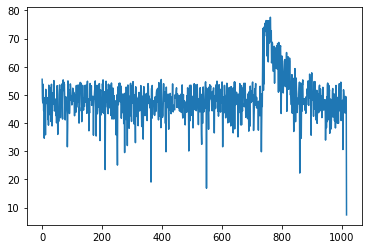

In [6]:
## amplitude to dB
X_train_dB = librosa.amplitude_to_db(X_train)
X_test_dB = librosa.amplitude_to_db(X_test)

plt.figure()
plt.plot(X_train[0])
# plt.figure()
# plt.plot(X_train[1])
plt.figure()
plt.plot(X_train_dB[0])

## nomalization
# scaler = preprocessing.MinMaxScaler().fit(X_train)
# X_train_SC = scaler.transform(X_train)
# X_test_SC = scaler.transform(X_test)

# plt.figure()
# plt.plot(X_train_SC[0])
# plt.figure()
# plt.plot(X_train_SC[1])


## Visualization Training set

In [7]:
from sklearn.manifold import TSNE

n_components = 2
n_sne = 1000
rand_list = np.random.randint(0,len(X_train_dB),size=n_sne)

tsne = TSNE(n_components=2, verbose=1, n_iter=500)
tsne_result = tsne.fit_transform(X_train_dB[rand_list])


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.034s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 37.196746
[t-SNE] KL divergence after 250 iterations with early exaggeration: 93.931664
[t-SNE] KL divergence after 500 iterations: 1.694942


In [8]:
from sklearn.preprocessing import LabelEncoder

labels = y_train[rand_list]
labels = labels.astype('int')
items = ['NLOS', 'LOS']
encoder = LabelEncoder()
encoder.fit(items)
label_inverted = encoder.inverse_transform(labels)
label_inverted.shape



(1000,)

<AxesSubplot:xlabel='x', ylabel='y'>

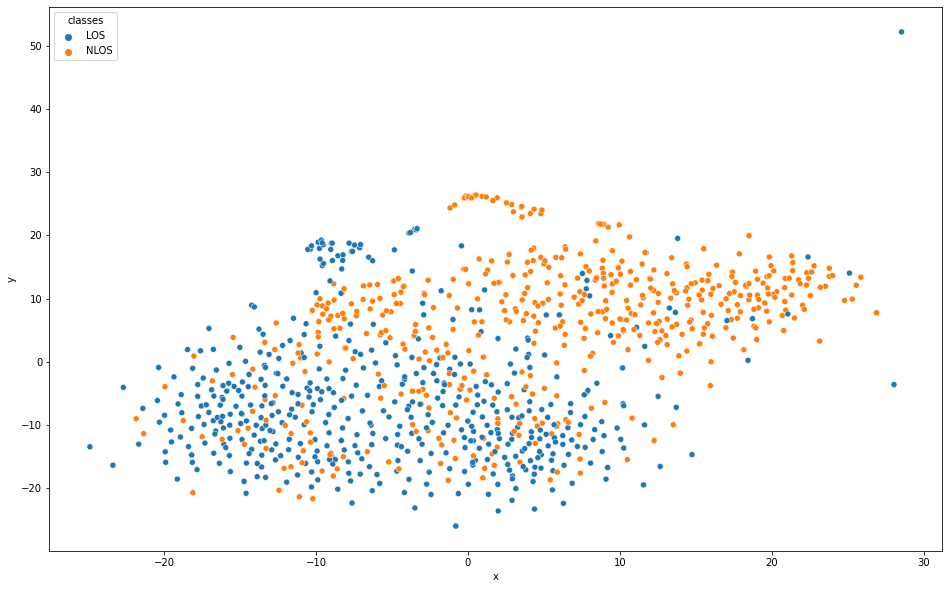

In [9]:
t_sne_df = pd.DataFrame({'x':tsne_result[:,0], 'y':tsne_result[:,1], 'classes':label_inverted})
plt.figure(figsize=(16,10))
sns.scatterplot(x='x', y='y',hue='classes',data=t_sne_df,legend="full", alpha=1)

In [10]:
idx_los = np.where(y_train==0)[0]
idx_nlos = np.where(y_train==1)[0]
print(idx_los)
print(idx_nlos)
X_train_dB = X_train_dB.reshape(-1,1,1016)
X_test_dB = X_test_dB.reshape(-1,1,1016)
# X_test_vec.shape




[    7     8     9 ... 37797 37798 37799]
[    0     1     2 ... 37787 37791 37796]


In [25]:
class SiameseNetworkDataset():
    
    def __init__(self,training_data=None,training_dir=None, setSize=None, transform=None):
        # used to prepare the labels and images path
        self.training_data = training_data
        # self.training_df.columns =["image1","image2","label"]
        self.training_dir = training_dir    
        self.transform = transform
        self.setSize = setSize

    def __len__(self):
        return self.setSize
    def __getitem__(self,idx):
        # get class index
        idx_los = np.where(self.training_dir==0)[0]
        idx_nlos = np.where(self.training_dir==1)[0]
        # select label
        if idx % 2 == 0:
            category = random.randint(0,1)
            if category == 0:
                img1_idx = random.choice(idx_los) # LOS
                img2_idx = random.choice(idx_los)
                
            else:
                img1_idx = random.choice(idx_nlos) # NLOS
                img2_idx = random.choice(idx_nlos)
            img1 = self.training_data[img1_idx] 
            img2 = self.training_data[img2_idx]
            label = 1.0

        else:
            category2 = random.randint(0,1)
            if category2 == 0:
                img1_idx = random.choice(idx_los)
                img2_idx = random.choice(idx_nlos)
            else:
                img1_idx = random.choice(idx_nlos)
                img2_idx = random.choice(idx_los)
            img1 = self.training_data[img1_idx] 
            img2 = self.training_data[img2_idx]
            label = 0.0

        img1 = torch.FloatTensor(img1)
        img2 = torch.FloatTensor(img2)

        return img1, img2, torch.from_numpy(np.array([label], dtype=np.float32))



In [12]:

# creates n-way one shot learning evaluation
class SiameseEvalSet(Dataset):
    def __init__(self, test_data, test_dir, setSize, numWay, transform=None):
        self.test_data = test_data
        # self.test_df.columns =["image1","image2","label"]
        self.test_dir = test_dir    
        self.transform = transform
        self.setSize = setSize
    def __len__(self):
        return self.setSize
    def __getitem__(self, idx):
        idx_los = np.where(self.test_dir==0)[0]
        idx_nlos = np.where(self.test_dir==1)[0]
        # find one main image, 0 is LOS , 1 is NLOS
        category = random.randint(0,1)
        if category == 0: # if selected label is LOS
            mainimg_idx = random.choice(idx_los) # LOS
        else:
            mainimg_idx = random.choice(idx_nlos) 

        mainimg = test_data[mainimg_idx]
        if self.transfrom:
            mainImg = self.transfrom(mainimg)

        # find n numbers of distinct images, 1 in the same set as the main
        testSet = []
        label = np.random.randint(self.numWay) # 0 or 1
        for i in range(self.numWay):
            if i == label:
                if category == 0:
                    test_idx = random_choice(idx_los)
                else:
                    test_idx = random.choice(idx_nlos)
            else:
                if category == 0:
                    test_idx = random.choice(idx_nlos)
                else:
                    test_idx = random.choice(idx_los)

            testImg = test_data[test_idx]
            if self.transform:
                testImg = self.transform(testImg)
            testSet.append(testImg)
            # plt.imshow()
            return mainImg, testSet, torch.from_numpy(np.array([label], dtype = int))
            

In [53]:
# choose a training dataset size and further divide it into train and validation set 80:20
dataSize = 100000 # self-defined dataset size
TRAIN_PCT = 0.8 # percentage of entire dataset for training
train_size = int(dataSize * TRAIN_PCT)
val_size = dataSize - train_size
print(train_size,val_size)
transformations = transforms.Compose(
    [transforms.ToTensor()]) 

CIRdataset = SiameseNetworkDataset(training_data = X_train_dB, training_dir=y_train, setSize=dataSize, transform=None)
train_set, val_set = random_split(CIRdataset, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, num_workers=2, shuffle=True)

80000 20000


tensor([[0.]])
tensor([[[46.4029, 47.6042, 49.0969,  ..., 38.8897, 45.2014, 48.1648]]])


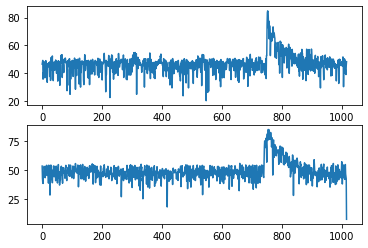

In [54]:
# Viewing the sample of images and to check whetehr its loading properly
dataloader = DataLoader(CIRdataset,
                        shuffle=True,
                        batch_size=1)
dataiter = iter(dataloader)

image1, image2, label = dataiter.next()

print(label)
print(image1)
plt.figure()
plt.subplot(211)
plt.plot(image1.squeeze())
plt.subplot(212)
plt.plot(image2.squeeze())

# concatenated = torch.cat((example_batch[0],example_batch[1]),0)
# imshow(torchvision.utils.make_grid(concatenated))
# print(example_batch[2].numpy())

In [55]:
class GlobalMaxPooling1D(nn.Module):
    def __init__(self, data_format='channels_last'):
        super(GlobalMaxPooling1D, self).__init__()
        self.data_format = data_format
        self.step_axis = 1 if self.data_format == 'channels_last' else 2

    def forward(self, input):
        return torch.max(input, axis=self.step_axis).values

In [73]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        # Conv2d(input_channels, output_channels, kernel_size)
        self.cnn1 = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=10, kernel_size=4),
            nn.ReLU(inplace=True),
            nn.Conv1d(in_channels=10, out_channels=20, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(in_channels=20, out_channels=20, kernel_size=4),
            nn.ReLU(inplace=True),
            nn.Conv1d(in_channels=20, out_channels=40, kernel_size=4),
            GlobalMaxPooling1D())

        self.fc1 = nn.Sequential(
            nn.Linear(128 * 498, 128),
            nn.Linear(128, 128))
            
    
    def forward_once(self,x):
        output = self.cnn1(x)
        output = torch.flatten(output)
        output = self.fc1(output)
        return output
    
    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2
        

In [74]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [75]:
def count_parameters(model):
    
    temp = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'The model architecture:\n\n', model)
    print(f'\nThe model has {temp:,} trainable parameters')
    
count_parameters(net)

The model architecture:

 SiameseNetwork(
  (cnn1): Sequential(
    (0): Conv1d(1, 10, kernel_size=(4,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(10, 20, kernel_size=(5,), stride=(1,))
    (3): ReLU(inplace=True)
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv1d(20, 20, kernel_size=(4,), stride=(1,))
    (6): ReLU(inplace=True)
    (7): Conv1d(20, 40, kernel_size=(4,), stride=(1,))
    (8): GlobalMaxPooling1D()
  )
  (fc1): Sequential(
    (0): Linear(in_features=63744, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=1, bias=True)
  )
)

The model has 8,165,419 trainable parameters


In [82]:
# training and validation after every epoch
def train(model, train_loader, val_loader, num_epochs, criterion, save_name,device):
    best_val_loss = float("Inf") 
    train_losses = []
    val_losses = []
    cur_step = 0
    for epoch in range(num_epochs):
        running_loss = 0.0
        model.train()
        print("Starting epoch " + str(epoch+1))
        for img1, img2, labels in train_loader:
            
            # Forward            
            img1 = img1.to(device)
            img2 = img2.to(device)
            labels = labels.to(device)
            output1, output2 = model(img1,img2)
            output1 = output1.unsqueeze(0)
            output2 = output2.unsqueeze(0)
            optimizer.zero_grad()
            
            # outputs = model(img1, img2)
            loss_contrastive = criterion(output1,output2, labels)
            loss_contrastive.backward()
            optimizer.step()
            
            # Backward and optimize
            running_loss += loss_contrastive.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        val_running_loss = 0.0
        with torch.no_grad():
            model.eval()
            for img1, img2, labels in val_loader:
                img1 = img1.to(device)
                img2 = img2.to(device)
                labels = labels.to(device)
                output1, output2 = model(img1,img2)
                output1 = output1.unsqueeze(0)
                output2 = output2.unsqueeze(0)
                loss_contrastive = criterion(output1,output2, labels)
                val_running_loss += loss_contrastive.item()
        avg_val_loss = val_running_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        print('Epoch [{}/{}],Train Loss: {:.4f}, Valid Loss: {:.8f}'
            .format(epoch+1, num_epochs, avg_train_loss, avg_val_loss))
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            save_checkpoint(save_name, model, optimizer, best_val_loss)
    
    print("Finished Training")  
    return train_losses, val_losses  

# evaluation metrics
def eval(model, test_loader):
    with torch.no_grad():
        model.eval()
        correct = 0
        print('Starting Iteration')
        count = 0
        for mainImg, imgSets, label in test_loader:
            mainImg = mainImg.to(device)
            predVal = 0
            pred = -1
            for i, testImg in enumerate(imgSets):
                testImg = testImg.to(device)
                output = model(mainImg, testImg)
                if output > predVal:
                    pred = i
                    predVal = output
            label = label.to(device)
            if pred == label:
                correct += 1
            count += 1
            if count % 20 == 0:
                print("Current Count is: {}".format(count))
                print('Accuracy on n way: {}'.format(correct/count))

In [83]:
# actual trainingd
import torch.optim as optim
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(net.parameters(), lr = 0.0006)
net = SiameseNetwork()
criterion = ContrastiveLoss()
num_epochs = 50
save_path = 'siameseNet-batchnorm50.pt'
train_losses, val_losses = train(net, train_loader, val_loader, num_epochs, criterion, save_path, device)

Starting epoch 1
torch.Size([128, 498])
tensor([1.7200, 1.6592, 1.6865,  ..., 2.0696, 2.2843, 1.8011],
       grad_fn=<ViewBackward>)
torch.Size([128, 498])
tensor([1.4819, 1.6954, 1.5844,  ..., 2.1423, 1.5632, 1.5012],
       grad_fn=<ViewBackward>)
torch.Size([128, 498])
tensor([1.6728, 2.0406, 2.1637,  ..., 1.8922, 1.8825, 2.0486],
       grad_fn=<ViewBackward>)
torch.Size([128, 498])
tensor([1.5192, 1.4873, 1.7379,  ..., 1.9506, 1.8854, 1.7259],
       grad_fn=<ViewBackward>)
torch.Size([128, 498])
tensor([1.4935, 1.5656, 1.5607,  ..., 1.7470, 1.7289, 1.8861],
       grad_fn=<ViewBackward>)
torch.Size([128, 498])
tensor([1.8628, 1.8954, 1.8765,  ..., 1.9225, 1.8385, 1.6496],
       grad_fn=<ViewBackward>)
torch.Size([128, 498])
tensor([1.8905, 1.6453, 1.9685,  ..., 1.7483, 1.6855, 1.7215],
       grad_fn=<ViewBackward>)
torch.Size([128, 498])
tensor([1.8649, 2.1511, 2.0739,  ..., 1.9137, 1.8210, 2.0480],
       grad_fn=<ViewBackward>)
torch.Size([128, 498])
tensor([1.8186, 1.8463, 

KeyboardInterrupt: 